In [1]:
import pandas as pd
import numpy as np
import spacy
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from nltk.corpus import stopwords
import re
import matplotlib.pyplot as plt
%matplotlib inline

# Wordcloud on clustering results

You can easily create a wordcloud for your clustering result in 2 step:
(You only need to modify parameters in step 2. Takes 10-15 min to run.)

1. Generate clustering result in the format of ../data/clustering/progress_report2_assignment_backup.csv and read it here.

In [2]:
filename = '../data/clustering/progress_report2_assignment_backup.csv'
cluster_assignments = pd.read_csv(filename,index_col=0)

In [3]:
# max_cluster_metric

In [4]:
cluster_assignments.columns

Index(['pubId', 'canonicalUrl', 'firstScrape', 'title', 'text',
       'lang_reliability', 'lang_iso', 'title_len', 'text_len', 'label',
       'cluster__entity_tfidf', 'cluster__doc2vec', 'cluster__bow',
       'cluster__bert_spacy', 'cluster__bert', 'cluster__bow_lemma',
       'cluster__kmean_bow', 'cluster__bert_clean_spacy',
       'cluster__entity_tfidf_3:6', 'cluster__entity_tfidf_6:9',
       'cluster__entity_tfidf_9:12', 'cluster__entity_tfidf_12:15',
       'cluster__entity_tfidf_15:18', 'cluster__entity_tfidf_18:21',
       'cluster__entity_tfidf_21:24', 'cluster__entity_tfidf_24:27',
       'cluster__entity_tfidf_27:30'],
      dtype='object')

In [5]:
cluster_assignments.head()

,pubId,canonicalUrl,firstScrape,title,text,lang_reliability,lang_iso,title_len,text_len,label,...,cluster__bert_clean_spacy,cluster__entity_tfidf_3:6,cluster__entity_tfidf_6:9,cluster__entity_tfidf_9:12,cluster__entity_tfidf_12:15,cluster__entity_tfidf_15:18,cluster__entity_tfidf_18:21,cluster__entity_tfidf_21:24,cluster__entity_tfidf_24:27,cluster__entity_tfidf_27:30
62,290,zerohedge.com/news/2018-07-19/fbi-chief-threat...,7/19/2018 8:26:52 AM -04:00,FBI Chief Threatens To Quit If Trump Invites R...,"by Knave Dave - Jul 18, 2018 1:11 pm ### This ...",1,en,78,2858,helsinki,...,0,-1,-1,-1,-1,-1,-1,-1,-1,-1
10741,33,washingtonpost.com/news/morning-mix/wp/2018/07...,7/19/2018 11:51:57 PM -04:00,At least 8 reported dead as duck boat sinks ne...,At least 8 reported dead as duck boat sinks ne...,1,en,91,856,duckboat,...,0,-1,1,-1,1,1,1,1,1,1
10846,33,washingtonpost.com/news/posteverything/wp/2018...,7/19/2018 6:27:03 AM -04:00,"Ukraine’s not a country, Putin told Bush. What...",PostEverything Perspective ### Perspective Int...,1,en,79,8487,helsinki,...,0,-1,-1,-1,-1,-1,-1,-1,-1,-1
13359,237,hotair.com/archives/2018/07/19/looking-glass-d...,7/19/2018 1:35:59 PM -04:00,"Through the looking glass: Democrats attack ""R...",Through the looking glass: Democrats attack “R...,1,en,86,4440,helsinki,...,0,-1,-1,-1,-1,-1,-1,-1,3,3
16352,118,philly.com/philly/news/nation_world/20180719_a...,7/19/2018 11:15:42 PM -04:00,Sheriff: 8 people dead after Missouri tourist ...,Sheriff: 8 people dead after Missouri tourist ...,1,en,68,766,duckboat,...,0,4,4,4,4,1,4,4,4,3


In [6]:
def do_wordcloud(filename, model_name):
    
    def avg_tfidf(clustered_articles):
        vectorizer = TfidfVectorizer()
        vectors = vectorizer.fit_transform(clustered_articles)
        return np.mean(vectors, axis = 0), vectorizer
    
#     filename = '../data/clustering/progress_report2_assignment_backup.csv'
    cluster_assignments = pd.read_csv(filename,index_col=0)
    cluster_assignments = cluster_assignments[cluster_assignments[model_name] != -1]
    count_df = cluster_assignments[cluster_assignments[model_name] != -1].groupby(['label', model_name]).size().reset_index(name='counts')
    pred_df = count_df[count_df.groupby(['label'])['counts'].transform(max) == count_df['counts']].drop('counts', axis = 1)
    pred_df.columns = ['prediction', model_name]
    pred_articles = cluster_assignments.merge(pred_df, left_on=model_name, right_on=model_name)
    #get the noun, verb, word entity for each articles
    nlp = spacy.load("en_core_web_sm")
    noun_phrases_list = []
    verb_phrases_list = []
    entites_list = []
    for text in pred_articles['text']:
        doc = nlp(text)
        noun_phrases_list.append([chunk.text for chunk in doc.noun_chunks])
        verb_phrases_list.append([token.lemma_ for token in doc if token.pos_ == "VERB"])
        entites_list.append([entity.text for entity in doc.ents])

    cleaned_entity_list = [[re.sub('[^a-zA-Z ]+', '', ent).strip() for ent in entites] for entites in entites_list]
    cleaned_entity_list = [[ce for ce in cleaned_entities if ce != ''] for cleaned_entities in cleaned_entity_list]
    pred_articles['cleaned_entities'] = [' '.join(c) for c in cleaned_entity_list]
    averaged_tfidfs = pred_articles[['cleaned_entities','prediction']].groupby(['prediction'])['cleaned_entities'].agg(avg_tfidf)
    
    stopwords_set = set(stopwords.words('english'))

    events = averaged_tfidfs.index
    for i in range(0, len(averaged_tfidfs)):
        tf, vec = averaged_tfidfs[i]
        wordcloud = WordCloud(background_color = 'white')
        tfidfs = pd.DataFrame(tf, columns=vec.get_feature_names())
        d = {}
        for k,v in tfidfs.T.reset_index().values:
            d[k] = v
        d = {key: d[key] for key in d if key not in stopwords_set}
        wc = wordcloud.generate_from_frequencies(d)

        plt.figure()
        plt.title(events[i])
        plt.imshow(wc)
        plt.axis("off")

2. Choose the clustering model that you want to create the wordcloud from its result. In this case, it is 'cluster__bert'. Then run the whole notebook. If there is an error, check the dataframe. Still an error? Call me.

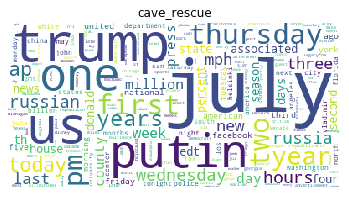

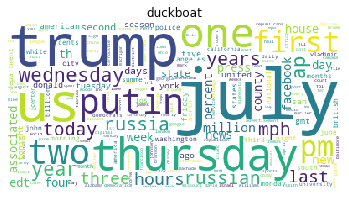

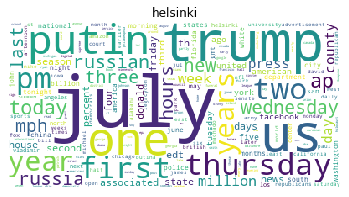

In [7]:
filename = '../data/clustering/progress_report2_assignment_backup.csv'
model_name = 'cluster__bow'
do_wordcloud(filename, model_name)
